# rl5E_lite_hyper.ipynb

Hyperparamter search of the `rl5E.ipynb` model using a genetic algorithm.

Regarding `rl5E`:
This notebook contains the fifth step in the 5-step process outlined in November 13th, 2020, in order to produce an actor-critic architecture for pendulum control. 

In step 1 we create a network with N units that takes the activity of 1 unit and transforms it into a bell-shaped representation.  
In step 2 we put 2 of those as the inputs to a (N/2)x(N/2) grid, and visualized.  
In step 3 we took the network from step 2 and connected it to the current SP and SD units in `test3p2` to see if the angle is being tracked.  
In step 4 we will connect a $V$ neuron to the L (RBF) layer, and tweak TD learning so its output starts to reflect the angular error.  
In step 5 the output of $V$ is used to configure a controller. There are three basic options outlined in the November 20th, 2020 entry of the log, and a fourth option in Nov. 30th. This fifth option was introduced in December 1st, 2020.

This started as a clone of `rl5C-Copy1`, which means it is setup for `rga_sig` units in C.

Currently transforming it into `rl5E_lite_hyper`.


In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
import pickle
#from tools.visualization import plotter
from multiprocessing import Pool

/home/sergio/projects/draculab/notebook


In [2]:
%cd spinal/rl
from rl5E_lite_from_cfg import rl5E_net

/home/sergio/projects/draculab/notebook/spinal/rl


In [3]:
# Specifying parameters and ranges in the configuration
focus_params = True # whether to focus mutations on a specific set of parameters

# Specify paramters and ranges
# defaults are based on incumbent 9 of smac_pars in v3_normal_smac_test.ipynb
ranges = {"C_sigma": {"low": 0.01, "high": 1., "default": 0.4 }, # yes
          "C_slope": {"low": 1., "high": 3., "default": 2. },
          "C_thresh": {"low": 0.0, "high": .2, "default":0.2},
          "C_integ_amp": {"low": 0.0, "high": 1.5, "default": 0.0},
          "C_custom_inp_del": {"low": 10, "high": 300, "default": 150}, # seemingly replaced in the code
          "M_des_out_w_abs_sum": {"low": 0.5, "high": 3., "default":1.6},
          "P_mu": {"low": .1, "high": 2., "default":1.},
          "P_inp_gain": {"low": 0.5, "high": 4., "default":2.},
          "SF_slope": {'low':0.5, "high":3., "default":2.},
          "V_slope": {"low": 0.3, "high": 2.5, "default":1.5}, #yes
          "V_delta": {"low": .2, "high": 4., "default":1.}, #yes
          "V_thresh": {"low": -0.1, "high": 2., "default":0.}, # no
          "V_td_lrate": {"low": 0.2, "high": 7., "default": 1.5}, # yes
          "V_td_gamma": {"low": 0.1, "high": .9, "default": .6}, # yes
          "V_w_sum": {"low": 10., "high": 100., "default": 60.}, # yes
          "X_slope": {"low": 2., "high": 10., "default":5.}, #yes
          "X_thresh": {"low": -0.2, "high": 1., "default":0.}, # no
          "X_del": {"low": 0., "high": 1.5, "default":0.3},
          "X_lrate": {"low": 50., "high": 400., "default":200.},
          "X_w_sum": {"low": 10., "high": 80., "default": 30.}, # yes
          "A__M_lrate": {"low": 0.05, "high": 10., "default":5.},
          "A__M_w_sum": {"low": 0.3, "high": 2., "default":.4},
          "A__M_w_max": {"low": 0.2, "high": .4, "default":.3},
          "M__C_lrate": {"low": 1., "high": 400., "default":100.}
         }

# if focus_params == True, ignore the other parameters
if focus_params:
    main_pars = ["V_slope", "V_delta", "V_td_lrate", "V_td_gamma",
                 "V_w_sum", "X_slope", "X_del", "X_lrate", "X_w_sum"]
    par_list = main_pars
else:
    par_list = list(ranges.keys())
    
def mutate(cfg, name_list=par_list):
    """ Mutate a single parameter of the given configuration. 
    
        Args:
            name_list: list with names of candidate parameters.
    """
    n = np.random.randint(len(name_list))
    par_name = name_list[n]
    l = ranges[par_name]['low']
    h = ranges[par_name]['high']
    cfg[par_name] =  l + (h-l)*np.random.random()
    
def soft_mutate(cfg, ma, name_list=par_list):
    """ Soft-mutate a single parameter of the given configuration.
    
        A 'soft mutation' keeps the mutated value close to the original value.
        The maximum amplitude of the mutation is given by the 'ma' argument.
        
        Args:
            ma : float in (0,1]. Max. amplitude as fraction of the parameter's range 
            name_list: list with names of candidate parameters.
    """
    n = np.random.randint(len(name_list))
    par_name = name_list[n]
    l = ranges[par_name]['low']
    h = ranges[par_name]['high']
    cfg[par_name] = max(l, min(h, cfg[par_name] + ma * (h-l) * (np.random.random()-0.5)))

In [4]:
# create an initial population from random range variations
pop_size = 60 # population size
n_def = 2 # number of individuals with default values
n_muts = 25 # number of mutations
n_soft_muts = 25 # number of soft mutations
pop = []

# first fill the population with default values
def_vals = {name : ranges[name]['default'] for name in par_list}
for ind in range(pop_size):
    pop.append(def_vals.copy())
        
# fill the rest with variations in both directions
chg_name = ["low", "default", "high"] # auxiliary list
for ind in range(n_def, pop_size):
    chg_dirs = [chg_name[i] for i in np.random.randint(3, size=len(par_list))]
    for idx, name in enumerate(par_list):
        pop[ind][name] = 0.5 * (ranges[name][chg_dirs[idx]] + ranges[name]["default"])
        
# Throw n_muts mutations, and n_soft_muts soft mutations
perm = np.random.permutation(range(n_def,pop_size))
for i in range(n_muts):
    mutate(pop[perm[i]])
for i in range(n_muts,n_muts+n_soft_muts):
    soft_mutate(pop[perm[i]], 0.2)

# reset fitness and number of evaluations
for dic in pop:
    dic['fitness'] = None # average fitness value
    dic['n_evals'] = 0  # number of times fitness has been evaluated
    
# For all the parameters not in main_pars, 
# fill cfg with the default values.
for cfg in pop:
    for name in ranges:
        if not name in cfg:
            cfg[name] = ranges[name]['default']

In [4]:
# Load the results from a previous run of rl5E_hyper
#%cd /home/z/projects/draculab/saves
%cd /home/sergio/projects/draculab/notebook/spinal/rl
fname = 'rl5E_lite_hyper_2021-01-22__12_47'
with (open(fname, "rb")) as f:
    pop = pickle.load(f)
    f.close()
    
# If the results are form a run with fewer parameters
# fill it with the default values.
for cfg in pop:
    for name in ranges:
        if not name in cfg:
            cfg[name] = ranges[name]['default']

/home/sergio/projects/draculab/notebook/spinal/rl


In [5]:
for cfg in pop:
    cfg['V_td_gamma'] = min(cfg['V_td_gamma'], 0.95)
    if 'X_l_rate' in cfg:
        cfg['X_lrate'] = cfg['X_l_rate']
        cfg.pop('X_l_rate')
        print('fixing', end=' ')

fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing fixing 

In [6]:
# print used configuration
for dic in pop[0:4]:
    print('{',end='')
    for name in dic.keys():
        if name != 'fitness' or dic['fitness'] != None:
            print("\'%s\':%.2f, " % (name, dic[name]), end='')
    print('}\n')

pop[0]

{'V_slope': 2.0, 
 'V_delta': 1.9351772436025465, 
 'V_td_lrate': 4.25, 
 'V_td_gamma': 0.95, 
 'V_w_sum': 35.0, 
 'X_slope': 3.5, 
 'X_del': 0.9, 'X_lrate': 200.0, 'X_w_sum': 62.666806463642374, 'fitness': 0.2863618487384629, 'n_evals': 2, 'C_sigma': 0.4, 'C_slope': 2.0, 'C_thresh': 0.2, 'C_integ_amp': 0.0, 'C_custom_inp_del': 150, 'M_des_out_w_abs_sum': 1.6, 'P_mu': 1.0, 'P_inp_gain': 2.0, 'V_thresh': 0.0, 'X_thresh': 0.0, 'A__M_lrate': 5.0, 'A__M_w_sum': 0.4, 'A__M_w_max': 0.3, 'M__C_lrate': 100.0, 'SF_slope': 2.0, 'X_lrate': 200.0}

{'V_slope':2.00, 'V_delta':1.94, 'V_td_lrate':4.25, 'V_td_gamma':0.95, 'V_w_sum':35.00, 'X_slope':3.50, 'X_del':0.90, 'X_w_sum':62.67, 'fitness':0.29, 'n_evals':2.00, 'C_sigma':0.40, 'C_slope':2.00, 'C_thresh':0.20, 'C_integ_amp':0.00, 'C_custom_inp_del':150.00, 'M_des_out_w_abs_sum':1.60, 'P_mu':1.00, 'P_inp_gain':2.00, 'V_thresh':0.00, 'X_thresh':0.00, 'A__M_lrate':5.00, 'A__M_w_sum':0.40, 'A__M_w_max':0.30, 'M__C_lrate':100.00, 'SF_slope':2.00, 'X_lrate':200.00, }

{'V_slope':0.90, 'V_delta':2.50, 'V_td_lrate':4.25, 'V_td_gamma':0.60, 'V_w_sum':80.00, 'X_slope':5.70, 'X_del':0.30, 'X_w_sum':55.00, 'fitness':0.30, 'n_evals':3.00, 'C_sigma':0.40, 'C_slope':2.00, 'C_thresh':0.20, 'C_integ_amp':0.00, 'C_custom_inp_del':150.00, 'M_des_out_w_abs_sum':1.60, 'P_mu':1.00, 'P_inp_gain':2.00, 'V_thresh':0.00, 'X_thresh':0.00, 'A__M_lrate':5.00, 'A__M_w_sum':0.40, 'A__M_w_max':0.30, 'M__C_lrate':100.00, 'SF_slope':2.00, 'X_lrate':300.00, }

{'V_slope':1.10, 'V_delta':2.50, 'V_td_lrate':1.50, 'V

{'V_slope': 2.0,
 'V_delta': 1.9351772436025465,
 'V_td_lrate': 4.25,
 'V_td_gamma': 0.95,
 'V_w_sum': 35.0,
 'X_slope': 3.5,
 'X_del': 0.9,
 'X_lrate': 200.0,
 'X_w_sum': 62.666806463642374,
 'fitness': 0.2863618487384629,
 'n_evals': 2,
 'C_sigma': 0.4,
 'C_slope': 2.0,
 'C_thresh': 0.2,
 'C_integ_amp': 0.0,
 'C_custom_inp_del': 150,
 'M_des_out_w_abs_sum': 1.6,
 'P_mu': 1.0,
 'P_inp_gain': 2.0,
 'V_thresh': 0.0,
 'X_thresh': 0.0,
 'A__M_lrate': 5.0,
 'A__M_w_sum': 0.4,
 'A__M_w_max': 0.3,
 'M__C_lrate': 100.0,
 'SF_slope': 2.0}

In [7]:
# A function to produce offspring by crossing individuals
par_names = list(pop[0].keys()) # list with all parameter names

def create_offspring(cfg1, cfg2, par_list=par_names):
    """ Given 2 configurations, return 2 offspring from random swapping.
    
        To produce offspring, first we choose one split point in the
        dictionary. The first offspring has the values of cfg1 up to that
        point, and cfg2 afterwards. The second offspring has the cfg2 values
        up to the split point, and cfg1 afterwards. Since the dictionaries are
        not ordered, we use a parameter list to set the split point.
    
        Args:
            cfg1, cfg2: parameter dictionaries
            par_list: list with the keys in cfg1, cfg2
        Returns:
            cfg3, cfg4: dictionaries from swapping values in cfg1, cfg2
    """
    if focus_params:
        par_list = main_pars
    sp = np.random.randint(len(par_list))# split point as an index to par_list
    cfg3 = cfg1.copy()
    cfg4 = cfg2.copy()
    for i in range(sp, len(par_list)):
        cfg3[par_list[i]] = cfg2[par_list[i]]
        cfg4[par_list[i]] = cfg1[par_list[i]]
    return cfg3, cfg4

# visualize
# cfg3, cfg4 = create_offspring(pop[10], pop[11])
# for dic in (pop[10], pop[11], cfg3, cfg4):
#     print('{',end='')
#     for name in par_names:
#         if name != "fitness":
#             print("\'%s\':%.2f, " % (name, dic[name]), end='')
#     print('}\n')


In [8]:
# A function that evaluates the fitness of a given configuration
def eval_config(cfg):
    """ Returns the error for a network with a given configuration.

        Args:
            cfg : a configuration dictionary.
        Returns:
            error : A float calculated from the sum of activities in the SPF layer.
    """
    if cfg['n_evals'] > 8: # if the fitness has been evaluated "enough" times. See cell below...
        return cfg['fitness']
    
    # obtain a network with the given configuration
    net, pops_dict = rl5E_net(cfg, 
                          pres_interv=5.,
                          rand_w=False,
                          par_heter=0.1,
                          x_switch=True,
                          V_normalize=True,
                          X_normalize=True)

#     for name in pops_dict:
#         exec(name + '=' + str(pops_dict[name]))
    #des_angs = np.array(des_angs)
    
    # run the network to learn the value (X switching)
    run_time = 4000.
    #start_time = time.time()
    times, data, plant_data  = net.run(run_time)
    #print('Execution time is %s seconds' % (time.time() - start_time))
    
    # run the network to learn to change afferent representations
    net.units[pops_dict['X'][0]].switch = False # stop swtiching
    run_time = 1000.
    times, data, plant_data  = net.run(run_time)
    
    # One last run for testing
    run_time = 500.
    times, data, plant_data  = net.run(run_time)
    data = np.array(data)
    
    # calculate average reward in last 500 seconds of reaching
    R = pops_dict['R']
    R_data = np.array(data[R])
    mean_R = np.mean(R_data)
    
    # extract L__V and L__X weigths
#     LVw = net.units[V[0]].buffer[1:,-1]
#     LXw = net.units[X[0]].buffer[1:,-1]

    return 1. - mean_R #, LVw, LXw

In [9]:
####################################
###### The genetic algorithm ######
####################################

# pop = pop[0:6] # limit pop size for debugging
n_mates = 15 # number of individuals to mate at each generation (even number)
max_gens = 18 # maximum number of generations
n_soft_mut = 10 # numbef of individuals to soft-mutate per generation
r_soft_mut = 0.2 # relative amplitude of soft mutations
n_mut = 5 # number of individuals to mutate per generation
n_procs = 60 # number of processes to use for fitness evaluation
n_save = 2 # number of individuals to protect from replacement and mutation
# setting name for file where parameters will be stored
fname = "rl5E_lite_hyper"
fname += "_" + datetime.now().strftime('%Y-%m-%d__%H_%M')

for gen in range(max_gens):
    start_time = time.time()
    # 1) Evaluate fitness
    # 1.1) Do the evaluation
    ######### Single process version
    #fits = list(map(eval_config, pop))
    ######## parallel version
    with Pool(n_procs) as p:
        fits = list(p.map(eval_config, pop)) #fits is a misnomer
        p.close()
        p.join()
    print(fits)
    # 1.2) update the average fitness values
    for idx, cfg in enumerate(pop):
        nr = cfg['n_evals'] # n_evals is not updated yet...
        #print(nr)
        #print(fits[idx])
        #print(cfg['fitness'])
        if nr > 0:
            if nr < 9: # horrible arbitrary number that might be different in eval_config :( 
                cfg['fitness'] = (cfg['fitness']*nr + fits[idx])/(nr+1)
        else:
            cfg['fitness'] = fits[idx]
        cfg['n_evals'] = cfg['n_evals'] + 1
    # 2) Sort according to fitness. Lowest error first.
    pop = sorted(pop, key=lambda d: d['fitness'])
    print('Top cfg this generation: ')
    print(pop[0])
    # 2.1) Save current generation
    with open(fname, 'wb') as f:
        pickle.dump(pop, f)
        f.close()
    # 2.2) A quick message
    print("Generation %d evaluated. Best fitness: %.3f"%(gen,pop[0]['fitness']))
    print("Mean fitness = %.3f"%(np.mean(np.array(fits))))
    # 2.3) If best fitness good enough, break
#     if pop[0]['fitness'] < 0.02:
#         print("Good enough parameters found. Stopping search.")
#         break
    # 3) mate and replace
    # 3.1) Select individuals to be replaced with probability proportional to error
    fits.sort() # sort the fitnesses (now in the same order as pop)
    fits = np.array(fits)
    fits = fits/fits.sum() # normalize fitnesses so they add to 1
    cumsum_fits = fits[:] # cumsum_fits[i] = sum(fits[:i])
    for i in range(1,len(cumsum_fits)):
        cumsum_fits[i] = cumsum_fits[i-1] + cumsum_fits[i]
    repl_list = [] # list with indexes of individuals to be replaced
    while len(repl_list) < n_mates:
        min_r = cumsum_fits[n_save] # don't replace the first n_save individuals
        r = min_r + (1.-min_r) * np.random.random()
        candidate = n_save
        for i in range(n_save, len(fits)):
            if cumsum_fits[i] > r:
                break
            candidate += 1
        if candidate in repl_list:
            continue
        else:
            repl_list.append(candidate)
    print("to replace: ", end='')
    print(repl_list)
    # 3.2) Arrange individuals in random pairs
    perm = np.random.permutation(n_mates) # this will do 
    # 3.3) mate
    new_pops = []
    for i in range(int(np.floor(n_mates/2))):
        off1, off2 = create_offspring(pop[perm[2*i]], pop[perm[2*i+1]])
        new_pops.append(off1)
        new_pops.append(off2)
    # 3.4) replace
    for i, cfg in enumerate(new_pops):
        pop[repl_list[i]] = cfg
    # 4) mutate
    # 4.1) soft mutations
    for _ in range(n_soft_mut):
        idx = np.random.randint(len(pop))
        if idx < n_save:
            copy = pop[idx].copy()
            soft_mutate(copy, r_soft_mut)
            pop[-idx-1] = copy
            pop[-idx-1]['fitness'] = None
            pop[-idx-1]['n_evals'] = 0
        else:
            soft_mutate(pop[idx], r_soft_mut)
            pop[idx]['fitness'] = None
            pop[idx]['n_evals'] = 0
    # 4.2) mutations
    # 4.2.1) select individuals to mutate
    # sq_fits = fits*fits
    #cumsum_sq_fits = fits * fits # cumsum_sq_fits[i] = sum(sq_fits[:i])
    cumsum_sq_fits = fits # proportional to fits, rather than its square
    cumsum_sq_fits = cumsum_sq_fits / cumsum_sq_fits.sum()
    for i in range(1,len(cumsum_sq_fits)):
        cumsum_sq_fits[i] = cumsum_sq_fits[i-1] + cumsum_sq_fits[i]
    mut_list = [] # list with indexes of individuals to be mutate
    while len(mut_list) < n_mut:
        r = np.random.random()
        candidate = 0
        for i in range(len(fits)):
            if cumsum_sq_fits[i] > r:
                break
            candidate += 1
        if candidate in mut_list:
            continue
        else:
            mut_list.append(candidate)
    print("to mutate: ", end='')
    print(mut_list)
    for idx in mut_list:
        if idx < n_save:
            copy = pop[idx].copy()
            mutate(copy)
            pop[-idx-1] = copy
            pop[-idx-1]['fitness'] = None
            pop[-idx-1]['n_evals'] = 0
        else:
            mutate(pop[idx])
            pop[idx]['fitness'] = None
            pop[idx]['n_evals'] = 0
            
    print('generation %d finished in %s seconds' % (gen, time.time() - start_time))
#     while len(mut_list) < n_mut:
#         min_r = cumsum_sq_fits[n_save] # don't mutate the first n_save individuals
#         r = min_r + (1.-min_r) * np.random.random()
#         candidate = n_save
#         for i in range(n_save, len(fits)):
#             if cumsum_sq_fits[i] > r:
#                 break
#             candidate += 1
#         if candidate in mut_list:
#             continue
#         else:
#             mut_list.append(candidate)
#     print("to mutate: ", end='')
#     print(mut_list)
#     for _ in range(n_mut):
#         idx = np.random.randint(len(pop))
#         mutate(pop[idx])
#         pop[idx]['fitness'] = None
#         pop[idx]['n_evals'] = 0
    

[0.47458188980676064, 0.32201241968871475, 0.3989116107427616, 0.3338069979634246, 0.3237715794934283, 0.33706062115355306, 0.39977270615234384, 0.4568807233843468, 0.3718522810259868, 0.29695362537339476, 0.3504961782117674, 0.3421543175279622, 0.3607597515183689, 0.3657358048569471, 0.40624482813454954, 0.46476463117435396, 0.37595054484674684, 0.34274638286811865, 0.3706424052739363, 0.380304751815026, 0.42404404802522844, 0.3493325040004627, 0.3921462216988284, 0.3123008463962188, 0.3178846353086465, 0.3735815956938743, 0.45900976207947, 0.3344645800423047, 0.33460519070984296, 0.3972395288962448, 0.36268134634386695, 0.396757064642427, 0.35971621548382826, 0.3518701934792262, 0.2771664766144061, 0.3133795326637031, 0.3579327381607468, 0.411231418776021, 0.3876101252388169, 0.36315001309006145, 0.4664801431243881, 0.38737818007242186, 0.3612275171879795, 0.3589032898093921, 0.47135562420294264, 0.45267326185032597, 0.4006329562798594, 0.470841856234691, 0.3459818468548468, 0.399334

Process ForkPoolWorker-656:
Process ForkPoolWorker-655:
Process ForkPoolWorker-653:
Process ForkPoolWorker-659:


KeyboardInterrupt: 

In [9]:
# print final population
for dic in pop[:4]:
    print('{',end='')
    for name in dic.keys():
        if name != 'fitness' or dic['fitness'] != None:
            print("\'%s\':%.2f, " % (name, dic[name]), end='')
    print('}\n')

pop[0]

{'M__C_lrate':100.00, 'C_custom_inp_del':19.00, 'L__X_w_sum':15.00, 'C_slope':2.00, 'C_integ_amp':0.01, 'C__C_init_w':-1.50, 'P_inp_gain':3.00, 'A__M_w_sum':1.45, 'P_mu':0.13, 'M_des_out_w_abs_sum':2.30, 'fitness':0.18, 'V_thresh':0.30, 'L__V_max_w':1.15, 'C_thresh':0.20, 'R_slope':-2.00, 'A__M_lrate':2.52, 'X_slope':6.00, 'A__M_w_max':0.75, 'n_evals':1.00, 'C_sigma':0.21, 'V_delta':2.50, 'L__V_gamma':0.77, 'V_slope':1.00, 'L__V_lrate':0.05, 'L__V_w_sum':15.00, 'R_thresh':3.00, 'L__X_lrate':0.60, 'X_thresh':2.00, }

{'M__C_lrate':50.50, 'L__V_lrate':0.05, 'L__X_w_sum':6.50, 'C_slope':1.50, 'C_integ_amp':0.01, 'C__C_init_w':-2.25, 'P_inp_gain':1.25, 'A__M_w_sum':1.45, 'P_mu':0.50, 'M_des_out_w_abs_sum':1.60, 'V_delta':0.60, 'fitness':0.47, 'L__V_max_w':1.15, 'C_thresh':0.10, 'R_slope':-0.50, 'A__M_lrate':2.52, 'X_slope':8.00, 'A__M_w_max':0.50, 'n_evals':1.00, 'C_sigma':0.83, 'V_thresh':1.15, 'L__V_gamma':0.77, 'V_slope':1.00, 'C_custom_inp_del':164.00, 'L__V_w_sum':13.40, 'R_thresh':3.

{'A__M_lrate': 2.525,
 'A__M_w_max': 0.75,
 'A__M_w_sum': 1.45,
 'C__C_init_w': -1.5,
 'C_custom_inp_del': 19.0,
 'C_integ_amp': 0.01,
 'C_sigma': 0.20500000000000002,
 'C_slope': 2.0,
 'C_thresh': 0.19793627045986945,
 'L__V_gamma': 0.7749999999999999,
 'L__V_lrate': 0.05,
 'L__V_max_w': 1.15,
 'L__V_w_sum': 15.0,
 'L__X_lrate': 0.6,
 'L__X_w_sum': 15.0,
 'M__C_lrate': 100.0,
 'M_des_out_w_abs_sum': 2.3,
 'P_inp_gain': 3.0,
 'P_mu': 0.12940915514827195,
 'R_slope': -2.0,
 'R_thresh': 3.0,
 'V_delta': 2.5,
 'V_slope': 1.0,
 'V_thresh': 0.3,
 'X_slope': 6.0,
 'X_thresh': 2.0,
 'fitness': 0.1810556618463572,
 'n_evals': 1}

In [ ]:
# Save the final population
fname = "v3_nst_afx_pop"
fname += "_" + datetime.now().strftime('%Y-%m-%d__%H_%M')
with open(fname, 'wb') as f:
    pickle.dump(pop, f)
    f.close()

In [3]:
net, pops_dict = rl5E_net({}, pres_interv=5, rand_w=False, par_heter=0.1)

In [21]:
pops_dict['X']

[159]

In [35]:
# Setting a static value for X
net.units[X[0]].thresh = 10. # high threshold makes output zero

In [4]:
sim_time = 20.
#ratio = 15.1 # cns-amd
ratio = 20. # breaker
#ratio = 1.6 # breaker, no L,V
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

# import cProfile
# import pstats
# cProfile.run('times, data, plant_data = net.run(2.)', 'restats')
# prof = pstats.Stats('restats')
# prof.sort_stats('cumulative').print_stats(30)
# data = np.array(data)

Expecting to finish at: 22:59 (400 seconds)
Execution time is 395.6908264160156 seconds
Finished at 23:00


In [3]:
# Setting, fixing controller weights
# standard values:
# A__M_mat = np.rray([[0.27141863, 0.29511766, 0.23279135, 0.20067437],
#                     [0.23307357, 0.1957229 , 0.28739239, 0.28380952]])

# M__C_mat = np.array([[0.0295056,  2.05108517],
#                      [2.05111951, 0.02950648]])
# limit values:
A__M_mat = np.array([[0.4, .5, 0.08, 0.018],
                    [0.05, 0. , 0.4, 0.5]])

M__C_mat = np.array([[0.,  2.15],
                     [2.15, 0.]])


for m_idx, m_id in enumerate(M):
    for c_idx, c_id in enumerate(C):
        syn_list = net.syns[c_id]
        for syn in syn_list:
            if syn.preID == m_id:
                syn.w = M__C_mat[c_idx, m_idx]
                syn.alpha = 1e-5 # slowing down learning
                break

for a_idx, a_id in enumerate(A):
    for m_idx, m_id in enumerate(M):
        syn_list = net.syns[m_id]
        for syn in syn_list:
            if syn.preID == a_id:
                syn.w = A__M_mat[m_idx, a_idx]
                syn.alpha = 1e-5 # slowing down learning
                break
                

In [3]:
# running in two stages. Initial high learning rate and viscosity.
sim_time = 150.
#ratio = 15.1 # cns-amd
#ratio = 20. # breaker
ratio = 1.6 # breaker, no L,V
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish firstst simulation at %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Initial execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

sim_time = 100.
net.plants[0].mu = 0.5
for i in [0,1]:
    for syn in net.syns[C[i]]:
        if syn.type == 'rga_21':
            syn.lrate = 100.
            syn.alpha = syn.lrate * net.min_delay

secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Second execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

Expecting to finish firstst simulation at 13:44 (240 seconds)
Initial execution time is 235.43489503860474 seconds
Finished at 13:44
Expecting to finish at: 13:46 (160 seconds)
Second execution time is 157.33214712142944 seconds
Finished at 13:46


In [18]:
net.units[SP[0]].set_function(lambda t: des_sf[int(round(t/15.))])

In [8]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = [np.array([])]
plant_data_back[0] = plant_data[0]

first_idx=0*200
second_idx=1*200
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data[0] = plant_data[0][first_idx:second_idx,:]

In [10]:
# recover the data
data = data_back
plant_data[0] = plant_data_back[0]
times = times_back

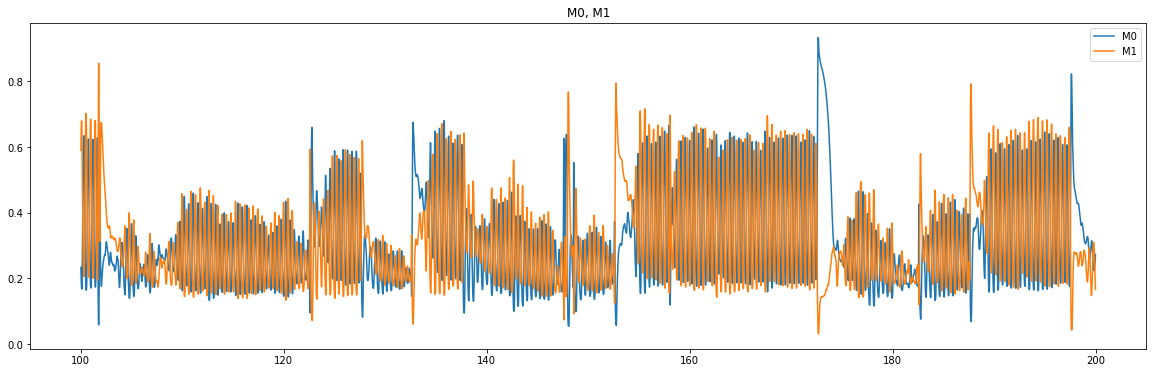

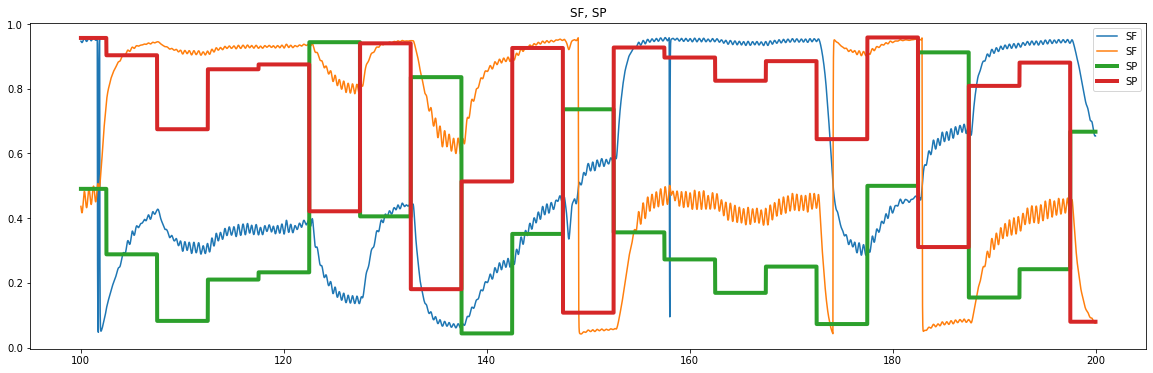

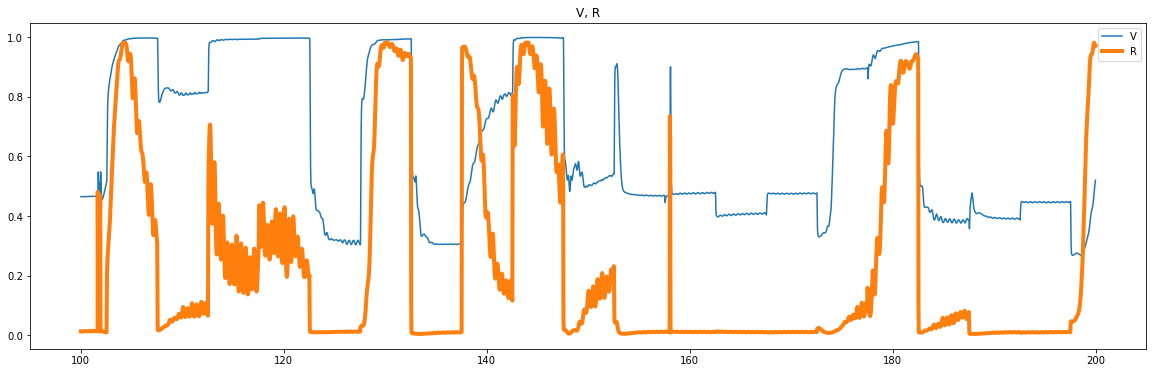

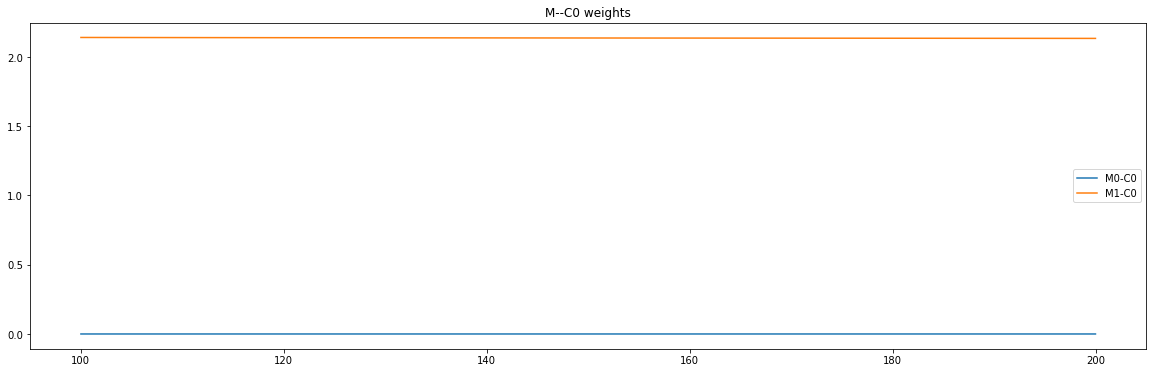

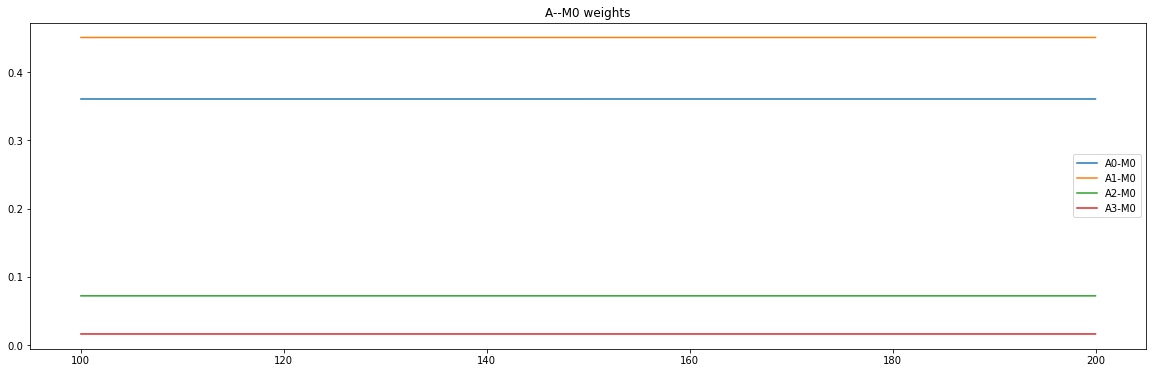

In [12]:
fs = (20,6)

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
plt.legend(['M0', 'M1'])
plt.title('M0, M1')
#print(M_data[:,-1])

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='SF')
plt.plot(times, SP_data.transpose(), label='SP', linewidth=4)
plt.legend()
plt.title('SF, SP')
plt.show()
#print('SF = [%f]' % (SF_data[0,-1]))
#print('SP = [%f]' % (SP_data[0,-1]))

# V, R
V_fig = plt.figure(figsize=fs)
V_data = np.array(data[V])
plt.plot(times, V_data.transpose())
plt.title('V, R')
R_data = np.array(data[R])
plt.plot(times, R_data.transpose(), linewidth=4)
plt.legend(['V', 'R'])

# M--C0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_C0_track])
plt.plot(times, w_track_data.transpose())
plt.legend(['M0-C0', 'M1-C0'])
plt.title('M--C0 weights')

# A--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[A_M0_track])
plt.plot(times, w_track_data2.transpose())
plt.legend(['A0-M0', 'A1-M0', 'A2-M0', 'A3-M0'])
plt.title('A--M0 weights')

plt.show()

Text(0.5, 1.0, 'SPF')

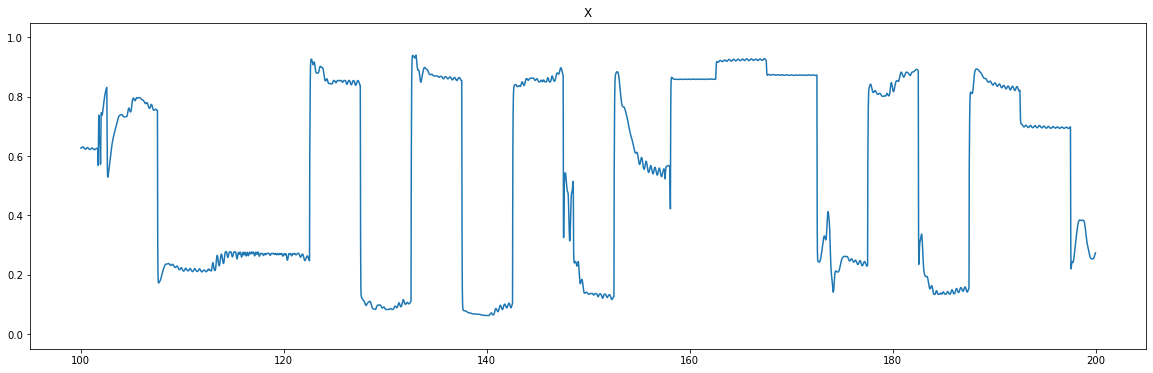

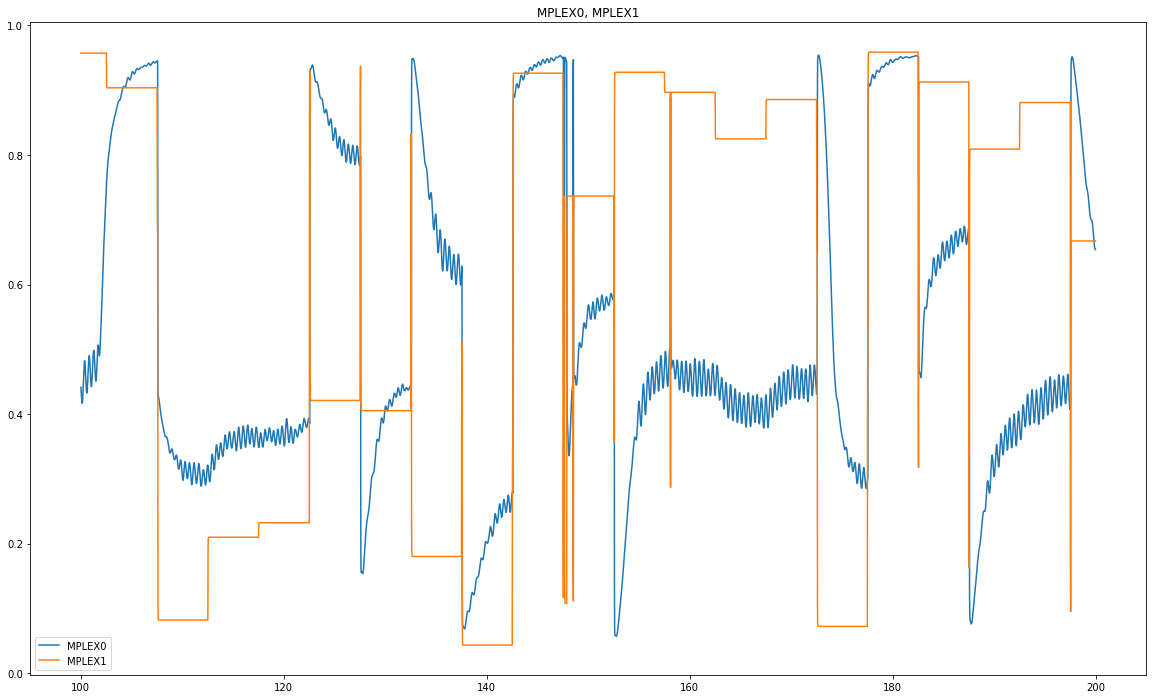

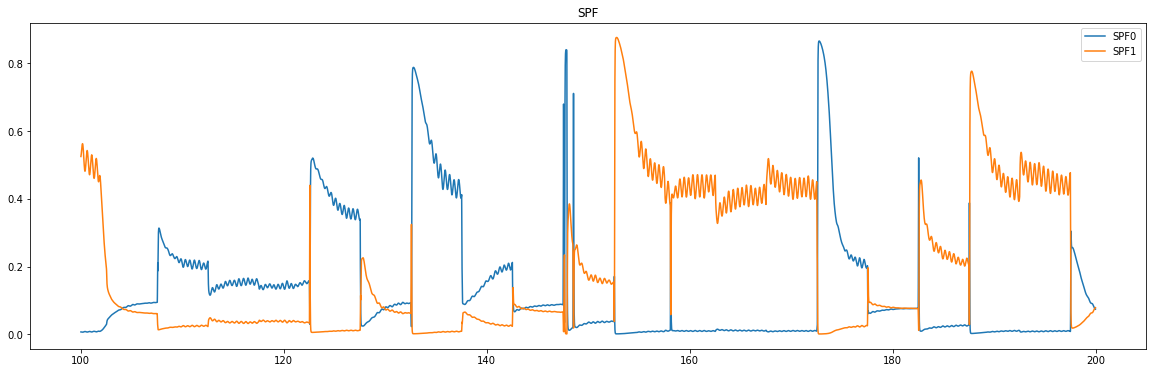

In [13]:
# X
X_fig = plt.figure(figsize=fs)
X_data = np.array(data[X])
plt.plot(times, X_data.transpose())
plt.ylim([-0.05,1.05])
#plt.legend(['X'])
plt.title('X')

fs = (20,12)
# MPLEX
MPLEX_fig = plt.figure(figsize=fs)
MPLEX_data = np.array(data[MPLEX])
plt.plot(times, MPLEX_data.transpose())
plt.legend(['MPLEX0', 'MPLEX1'])
plt.title('MPLEX0, MPLEX1')

# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
plt.legend(['SPF0', 'SPF1'])
plt.title('SPF')

Text(0.5, 1.0, 'C1')

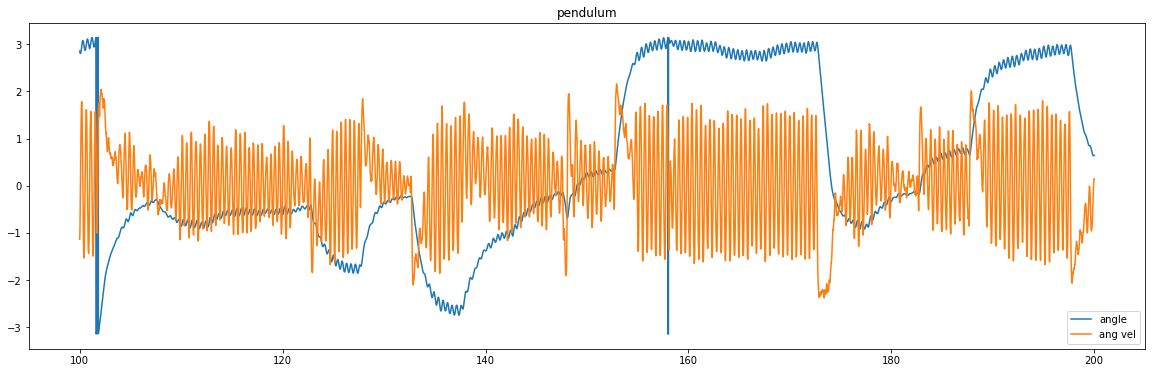

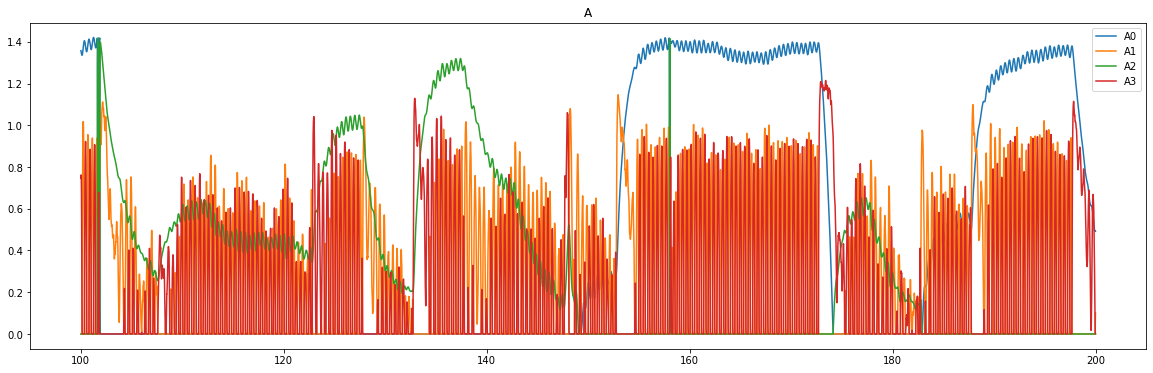

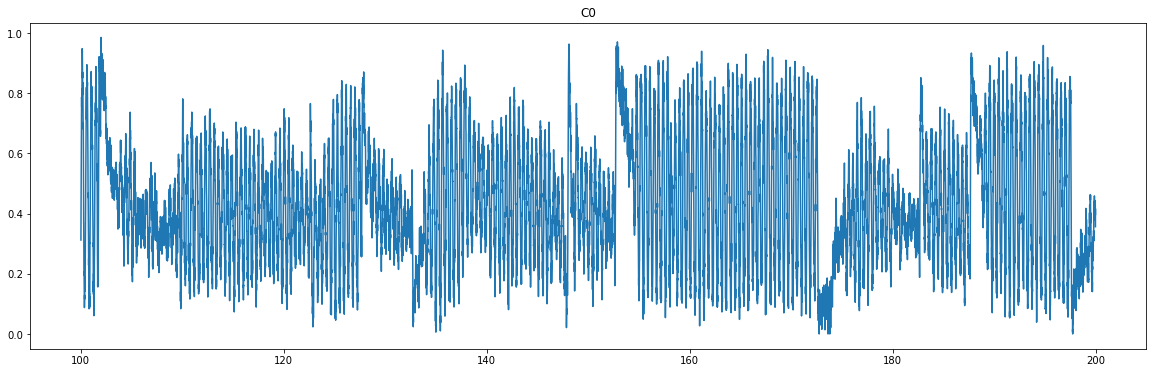

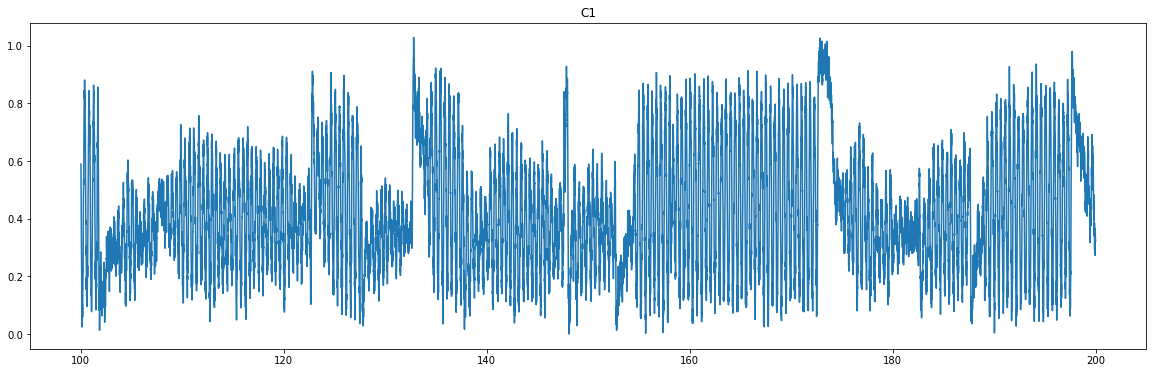

In [14]:
# P
P_fig = plt.figure(figsize=fs)
P_data = plant_data[P]
plt.plot(times, P_data[:,0], label='angle')
plt.plot(times, P_data[:,1], label='ang vel')
plt.legend()
plt.title('pendulum')
#print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

# A
A_fig = plt.figure(figsize=fs)
A_data = np.array(data[A])
plt.plot(times, A_data.transpose())
plt.legend(['A0', 'A1', 'A2', 'A3'])
plt.title('A')
#print(A_data[:,-1])

# L
# L_fig = plt.figure(figsize=fs)
# L_data = np.array(data[L])
# plt.plot(times, L_data.transpose())
# plt.title('L')

# C0
C0_fig = plt.figure(figsize=fs)
C0_data = np.array(data[C[0]])
plt.plot(times, C0_data.transpose())
#plt.plot(times, data[dc_track[0]], linewidth=3)
plt.title('C0')
#print(C0_data[-1])

# C1
C1_fig = plt.figure(figsize=fs)
C1_data = np.array(data[C[1]])
plt.plot(times, C1_data.transpose())
#plt.plot(times, data[dc_track[1]], linewidth=3)
plt.title('C1')
#print(C1_data[-1])


In [8]:
# Storing the M__C and A__M connections
M__C_mat = np.zeros((2,2)) # rows are target (C) neurons
for m_idx, m_id in enumerate(M):
    for c_idx, c_id in enumerate(C):
        syn_list = net.syns[c_id]
        for syn in syn_list:
            if syn.preID == m_id:
                M__C_mat[c_idx, m_idx] = syn.w
                break
                
A__M_mat = np.zeros((2,4)) # rows are target (M) neurons
for a_idx, a_id in enumerate(A):
    for m_idx, m_id in enumerate(M):
        syn_list = net.syns[m_id]
        for syn in syn_list:
            if syn.preID == a_id:
                A__M_mat[m_idx, a_idx] = syn.w
                break
print(M__C_mat)
print(A__M_mat)

[[0.         2.14115624]
 [2.14118386 0.        ]]
[[0.36072215 0.45091715 0.07213056 0.01623014]
 [0.04736244 0.         0.3789392  0.47369834]]


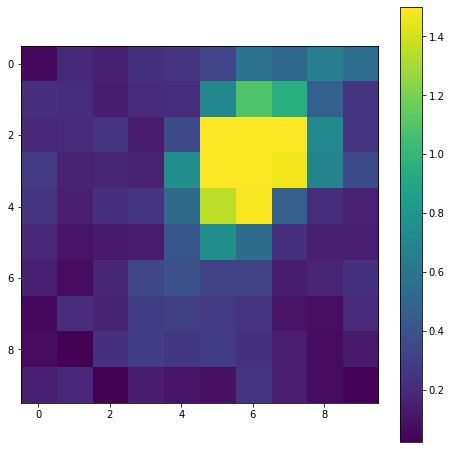

In [15]:
# L__V connections
L__V_w_mat = np.zeros((No2, No2))
for i in range(No2):
    for j in range(No2):
        w = net.syns[V[0]][i*No2 + j].w
        #print("%.2f" % (w), end=' ')
        L__V_w_mat[i,No2-j-1] = w
    #print("\n")
    
L__V_w_mat_fig = plt.figure(figsize=(8,8))
axs = plt.subplot(1,1,1)
cs = axs.imshow(L__V_w_mat)
L__V_w_mat_fig.colorbar(cs)
plt.show()

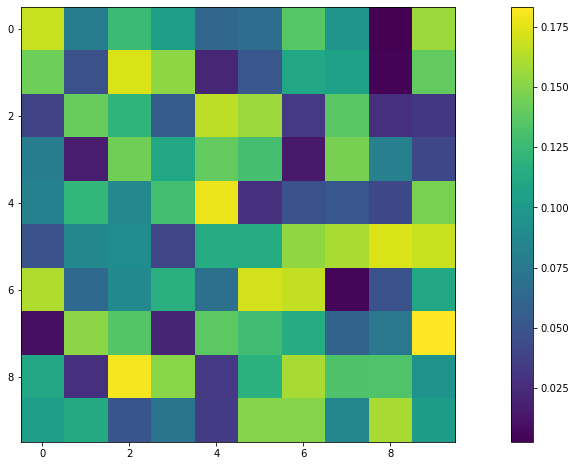

In [16]:
# L__X connections
matty0 = np.zeros((No2, No2))
matty1 = np.zeros((No2, No2))
for i in range(No2):
    for j in range(No2):
        w0 = net.syns[X[0]][i*No2 + j].w
        #w1 = net.syns[X[1]][i*No2 + j+4].w
        #print("%.2f" % (w), end=' ')
        matty0[i,No2-j-1] = w0
        #matty1[i,No2-j-1] = w1
    #print("\n")
    
matty_fig = plt.figure(figsize=(20,8))
axs0 = plt.subplot(1,1,1)
cs0 = axs0.imshow(matty0)
plt.colorbar(cs0)
# axs1 = plt.subplot(1,2,2)
# cs1 = axs1.imshow(matty1)
# plt.colorbar(cs1)
plt.show()

In [7]:
plotty = plotter(net, times, data)

In [12]:
plotty.act_anim(S1+S2+L+R+V, 0.5, interv=10, slider=False)

In [8]:
plotty.conn_anim(L, V)

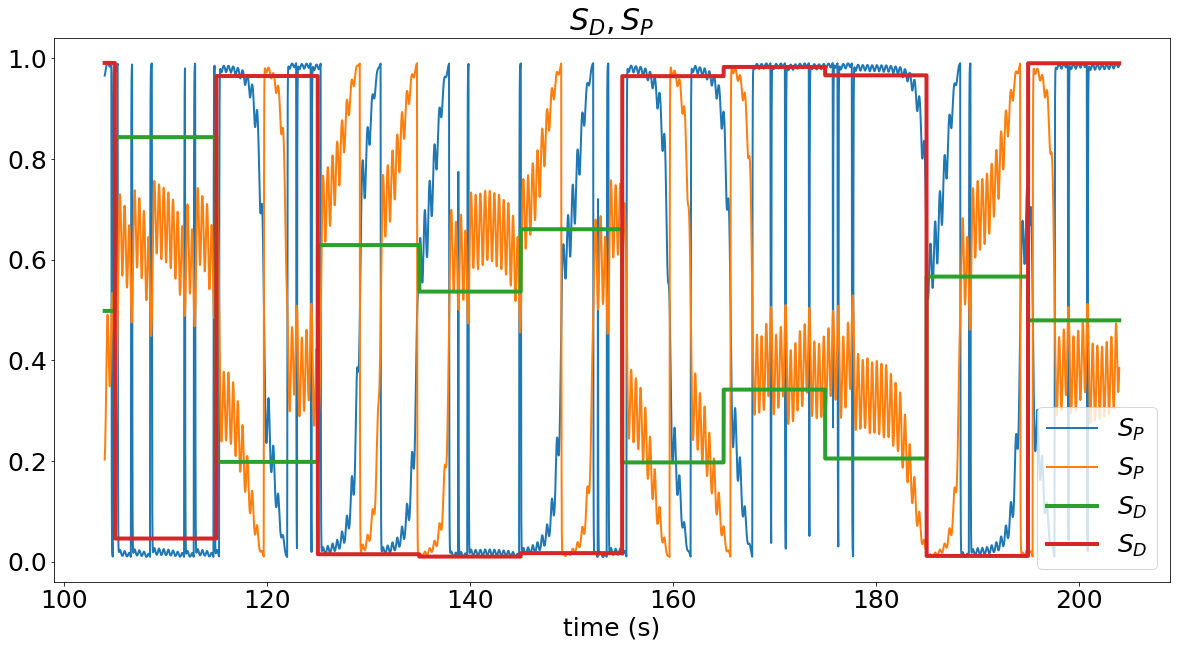

In [18]:
# A figure with more formatting
SPF_fig = plt.figure(figsize=(20,10))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='$S_P$', linewidth=2)
plt.plot(times, SP_data.transpose(), label='$S_D$', linewidth=4)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.xlabel('time (s)', fontsize =25)
plt.title('$S_D, S_P$', fontsize=30)
plt.show()

In [4]:
# good initial weights

# M__C
# M[0] has the F-D error, so you want C[0] (which exerts positive torque)
# to be driven by M[1] instead, and C[1] to be driven by M[0]
shift = 0
while not net.syns[C[0]][shift].type is synapse_types.rga:
    shift += 1
net.syns[C[0]][shift].w = 0.1
net.syns[C[0]][shift+1].w = 0.8 # C[0] driven by M[1]
net.syns[C[1]][shift].w = 0.8
net.syns[C[1]][shift+1].w = 0.1

# L__X, L__V
scale = 1. # maximum weight value
def dist(c1, c2):
    """ Periodic distance between 2-dim coordinates c1 and c2. 

        Assumes c1 and c2 are inside the box with corners [-0.5, -0.5], [0.5, 0.5].
    """
    x_dist = min(max(c1[0], c2[0]) - min(c1[0], c2[0]),  # "inner" distance
                 0.5-max(c1[0], c2[0]) + (min(c1[0], c2[0])+0.5) ) # "outer" distance
    y_dist = min(max(c1[1], c2[1]) - min(c1[1], c2[1]),  # "inner" distance
                 0.5-max(c1[1], c2[1]) + (min(c1[1], c2[1])+0.5) ) # "outer" distance
    return np.sqrt(x_dist*x_dist + y_dist*y_dist)

#L__V_iw = np.zeros((No2, No2))
j = 0
for i in range(len(L)):  # Setting L__V weights
    u = net.units[L[i]]
    c = u.coordinates
    d = dist(c, [c[1], c[1]])
    Vsyn = net.syns[V[0]][i]
    Xsyn = net.syns[X[0]][i+j]
    while Xsyn.type != synapse_types.diff_rm_hebbian:
        j +=1
        Xsyn = net.syns[X[0]][i+j]
    if Vsyn.preID == u.ID and Xsyn.preID == u.ID:
        a, b = divmod(i, No2)
        Vsyn.w = scale*(.5 - d)
        Xsyn.w = 0.01 if abs(c[1]-c[0]) < 0.5-max(c[1],c[0]) + min(c[1],c[0])+0.5 else .8
    else:
        print("FAILED!!!!!!!")

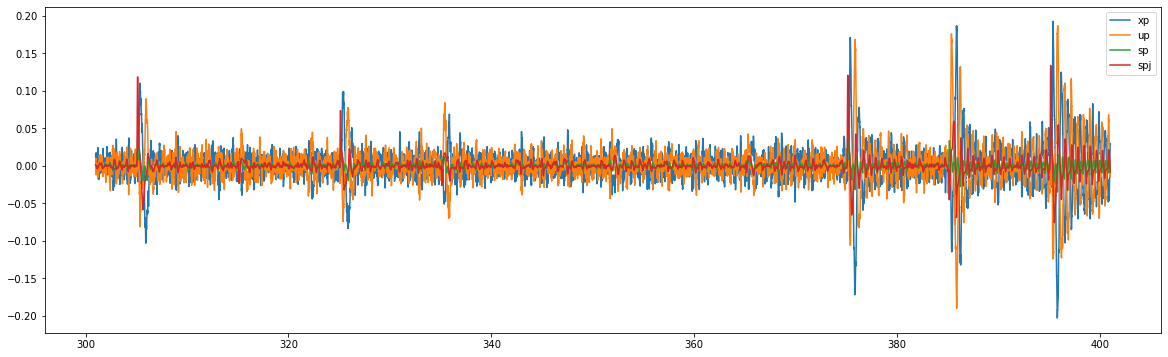

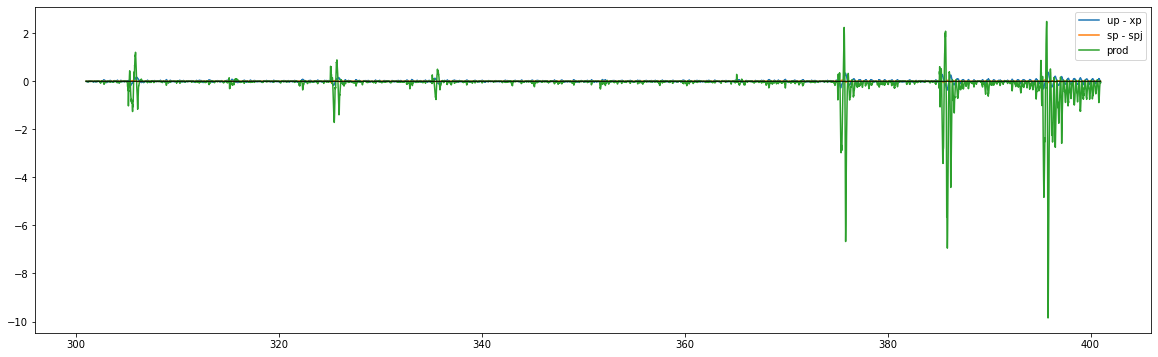

In [20]:
# plot all factors in the M--C0 synaptic plasticity
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

In [21]:
# checking some connections
print("Connections to M0 unit")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    #elif pre_id in L:
    #    pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    #elif pre_id in V:
    #    pre_pop = 'V'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M0, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to M1 unit")
for idx, syn in enumerate(net.syns[M[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    #elif pre_id in L:
    #    pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    #elif pre_id in V:
    #    pre_pop = 'V'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M1, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
    
print("Connections to C0 unit")
for idx, syn in enumerate(net.syns[C[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C0, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))  

print("Connections to C1 unit")
for idx, syn in enumerate(net.syns[C[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C1, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))  

    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[A[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
    
print("Connections to MPLEX units")
for idx, syn in enumerate(net.syns[MPLEX[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in X:
        pre_pop = 'X'
    elif pre_id in SF:
        pre_pop = 'SF'
    elif pre_id in SP:
        pre_pop = 'SP'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MPLEX, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in T:
        pre_pop = 'T'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%
          (idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to X unit")
for idx, syn in enumerate(net.syns[X[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in L:
        pre_pop = 'L'
    elif pre_id in V:
        pre_pop = 'V'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> X, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  
    
print("Connections to V unit")
for idx, syn in enumerate(net.syns[V[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in L:
        pre_pop = 'L'
    elif pre_id in R:
        pre_pop = 'R'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> V, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  


Connections to M0 unit
0) A (0) --> M0, w=0.360735, port=2, plant_out=None
1) A (1) --> M0, w=0.450918, port=2, plant_out=None
2) A (2) --> M0, w=0.072119, port=2, plant_out=None
3) A (3) --> M0, w=0.016227, port=2, plant_out=None
4) M (107) --> M0, w=-1.000000, port=3, plant_out=None
5) SPF (155) --> M0, w=1.000000, port=1, plant_out=None
Connections to M1 unit
0) A (0) --> M1, w=0.047355, port=2, plant_out=None
1) A (1) --> M1, w=0.000000, port=2, plant_out=None
2) A (2) --> M1, w=0.378924, port=2, plant_out=None
3) A (3) --> M1, w=0.473721, port=2, plant_out=None
4) M (106) --> M1, w=-1.000000, port=3, plant_out=None
5) SPF (156) --> M1, w=1.000000, port=1, plant_out=None
Connections to C0 unit
0) C (5) --> C0, w=-1.500000, port=1, plant_out=None
1) M (106) --> C0, w=0.000000, port=0, plant_out=None
2) M (107) --> C0, w=2.134397, port=0, plant_out=None
Connections to C1 unit
0) C (4) --> C1, w=-1.500000, port=1, plant_out=None
1) M (106) --> C1, w=2.134459, port=0, plant_out=None
2)

---